In [95]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [142]:
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
from scipy.integrate import solve_ivp
import sys
from tqdm.auto import tqdm

sys.path.append('/om2/user/eisenaj/code/DeLASE/')
from delase import DeLASE
from dmd import embed_signal_torch

sys.path.append('/om2/user/eisenaj/code/DSA/DSA')
from stats import *

sys.path.append('/om2/user/eisenaj/code/ChaoticConsciousness')
from data_utils import get_data_class, load_session_data, load_window_from_chunks


# Simple Linear Model

In [4]:
def g_dW(x, scale=1):
    return scale

In [155]:
lamb = 0.1
t_span = [0, 20]
dt = 0.001
t_eval = np.arange(t_span[0], t_span[1], dt)
T = len(t_eval)
N = 1
y0 = np.random.randn(N)
# sol = solve_ivp(lambda t, x: -lamb*x, t_span=t_span, y0=y0, t_eval=t_eval)
# x = sol.y.T
noise_scale = 0.01
dW = np.sqrt(dt) * np.random.randn(T,N)
x = np.zeros((T, N))
x[0] = y0
for t in range(1, T):
    x[t] = x[t-1] + (-lamb*x[t-1]) * dt + g_dW(x[t-1], scale=noise_scale) * dW[t]

observation_dims = 1
indices = np.random.choice(np.arange(N), size=observation_dims, replace=False)
x = x[:, indices]

device = 'cuda'

In [156]:
# CR_log = {}
# CR_I = {}
# delase_vals = {}
# aic_vals = []
# mse_vals = []
# mae_vals = []
# p_range = np.arange(1, 35)
# # num_obs = np.max(p_range) + 2
# # num_obs = x.shape[0]
# num_obs = 50
# for p in p_range:
#     # num_obs = p + 2
#     # subsample = 1
#     X = x[np.arange(num_obs)]
#     X_test = x[np.arange(num_obs, num_obs*2)]

#     # X = embed_signal_torch(X, p, 1).numpy()
#     # X_plus = X[1:]
#     # X_minus = X[:-1]
#     # A = np.linalg.lstsq(X_minus, X_plus, rcond=None)[0].T
#     # a = np.real(np.linalg.eigvals(A)).max()

#     # # normal delay embedding

#     # delase = DeLASE(X, p, delay_interval=1, device='cuda', dt=dt, max_freq=500, max_unstable_freq=125)
#     # delase.DMD.fit()
#     # a = np.real(np.linalg.eigvals(delase.DMD.A_havok_dmd.cpu().numpy())).max()

#     # CR_log[p] = -np.log(a)/(dt)
#     # CR_I[p] = -(a - 1)/(dt)

#     # preds = delase.DMD.predict(X_test).cpu()

#     # aic_vals.append(aic(preds, X_test, delase.DMD.rank))
#     # mse_vals.append(mse(preds, X_test))
#     # mae_vals.append(mae(preds, X_test))

#     # pade
#     H = X.copy()
#     H_test = X_test.copy()
#     n_delays = p - 1
#     for lag in np.arange(n_delays):
#         _tau = dt*((p - lag - 1))
#         filtered_signal = np.zeros(X.shape)
#         for t in range(1, X.shape[0]):
#             filtered_signal[t] = ((2*dt - _tau)/(_tau + 2*dt))*X[t] + (_tau/(_tau + 2*dt))*(filtered_signal[t-1] + X[t-1]) 
#         H = np.hstack([H, filtered_signal])
        
#         filtered_signal_test = np.zeros(X_test.shape)
#         for t in range(1, X_test.shape[0]):
#             filtered_signal[t] = ((2*dt - _tau)/(_tau + 2*dt))*X_test[t] + (_tau/(_tau + 2*dt))*(filtered_signal[t-1] + X_test[t-1]) 
#         H_test = np.hstack([H_test, filtered_signal_test])
#     delase = DeLASE(H, n_delays=1, device=device)
#     delase.DMD.compute_hankel()
#     delase.DMD.compute_svd()
#     delase.DMD.compute_havok_dmd()

#     H_pred = delase.DMD.predict(H_test)
#     preds = H_pred[:, :X_test.shape[1]].cpu()

#     # compute CR

#     # X = x[subsample*np.arange(num_obs)]
#     # delase = DeLASE(X, p, delay_interval=1, dt=dt*subsample, max_freq=500, max_unstable_freq=125)
#     # delase.fit()
#     # delase_vals[p] = -delase.stability_params.numpy()[:1].mean()

In [157]:
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(CR_log.keys(), CR_log.values())
# plt.plot(CR_I.keys(), CR_I.values())
# plt.plot(delase_vals.keys(), delase_vals.values())
# plt.axhline(lamb, color='k', linestyle='--')
# # plt.ylim([0.6, 1])
# # plt.xlim([0, 20])
# plt.ylim([-10, 10])
# plt.xlabel('Number of Delays')
# plt.ylabel('Estimated Contraction Rate')
# plt.title(f"Number of Observations = {num_obs}")

# plt.subplot(1, 2, 2)
# ax = plt.gca()
# lns = []
# lns += ax.plot(aic_vals, c='g', linestyle='--', label='aic')

# ax2 = plt.gca().twinx()
# lns += ax2.plot(mae_vals, c='r', linestyle='--', label='mae')
# ax2.legend(lns, [ln.get_label() for ln in lns])

# plt.show()

# Neural Data

In [131]:
session = 'MrJones-Anesthesia-20160210-01'

In [132]:
all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
variables = ['electrodeInfo', 'sessionInfo', 'trialInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, session_info, trial_info = session_vars['electrodeInfo'], session_vars['sessionInfo'], session_vars['trialInfo']

eyes_open = session_info['eyesOpen'][-1] if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']
eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']

section_times = dict( 
    wake=(trial_info['cpt_refTime'][0], session_info['drugStart'][0]),
    induction=(session_info['drugStart'][0], eyes_close),
    anesthesia=(eyes_close, session_info['drugStart'][1]),
    late_anesthesia=(session_info['drugStart'][1], session_info['drugEnd'][1]),
    recovery1=(session_info['drugEnd'][1], eyes_open),
    recovery2=(eyes_open, T*dt)
)

if 'MrJones' in session:
    section_times['wake_sac'] = (0, trial_info['cpt_refTime'][0])  

sections = list(section_times.keys())


In [133]:
dir_ = f"/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat/propofolPuffTone/{session}_lfp_chunked_20s"
directory = pd.read_pickle(os.path.join(dir_, "directory"))

In [134]:
session_info['drugStart'], trial_info['cpt_refTime']

(array([2656.22573333, 4456.22573333]),
 array([1595.52413333, 1600.3773    , 1606.4144    , ..., 7052.04426667,
        7058.5461    , 7063.37556667]))

In [135]:
lfp_vals = load_window_from_chunks(1600, 1650, directory)

In [136]:
x = lfp_vals

# Plot

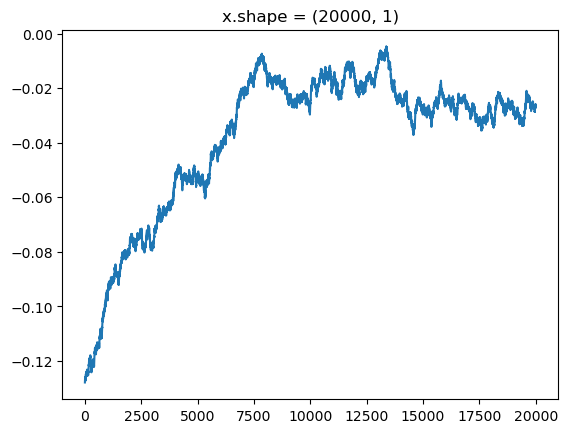

In [158]:
plt.plot(x[:, 0])
plt.title(f"x.shape = {x.shape}")
plt.show()

# Analyze

In [159]:
num_obs = x.shape[1]*1000
# num_obs = X.shape[1]*12
print(f"num_obs = {num_obs}")
print(f"max num delays = {(num_obs/2)/x.shape[1]}")

num_obs = 1000
max num delays = 500.0


In [160]:
subsample = 1
device = 'cuda'

CR_log = {}
CR_I = {}
CR_M = {}
delase_vals = {}
aic_vals = {}
mse_vals = {}
mase_vals = {}
p_range = np.arange(1, 64, 4)
# p_range = [20]
modes = ['DMD', 'pade', 'DMD-alt']
iterator = tqdm(total=len(p_range)*len(modes), desc='fitting models')
# num_obs = np.max(p_range) + 2

S_vals = []

for mode in modes:
    CR_log[mode] = {}
    CR_I[mode] = {}
    CR_M[mode] = {}
    aic_vals[mode] = []
    mse_vals[mode] = []
    mase_vals[mode] = []
    
    initial_svals = None
    for ind, p in enumerate(p_range):
        # num_obs = p + 2
        # subsample = 1
        X = x[np.arange(num_obs)]
        X_test = x[np.arange(num_obs, np.min([num_obs*2, x.shape[0]]))]

        # X = embed_signal_torch(X, p, 1).numpy()
        # X_plus = X[1:]
        # X_minus = X[:-1]
        # A = np.linalg.lstsq(X_minus, X_plus, rcond=None)[0].T
        # a = np.real(np.linalg.eigvals(A)).max()

        # normal DMD
        if mode == 'DMD':
            delase = DeLASE(X, p, delay_interval=1, device='cuda', dt=dt*subsample, max_freq=500, max_unstable_freq=125)
            # delase.DMD.fit()
            delase.DMD.compute_hankel()
            delase.DMD.compute_svd()
            # delase.DMD.V = delase.DMD.V/delase.DMD.S.max()
            # S_vals.append(delase.DMD.S.cpu().numpy())
            # delase.DMD.V = (torch.diag(1/delase.DMD.S) @ delase.DMD.V.T).T
            delase.DMD.compute_havok_dmd()
            
            preds = delase.DMD.predict(X_test).cpu()

        # linear filter DMD
        elif mode == 'linear-filter':
            H = X.copy()
            H_test = X_test.copy()
            n_delays = p - 1
            for lag in np.arange(n_delays):
                RC = dt*(p - lag - 1)
                alpha = dt/(RC + dt)
                filtered_signal = np.zeros(X.shape)
                for t in range(1, X.shape[0]):
                    filtered_signal[t] = filtered_signal[t-1] + alpha*(X[t] - filtered_signal[t- 1])
                H = np.hstack([H, filtered_signal])
                
                filtered_signal_test = np.zeros(X_test.shape)
                for t in range(1, X_test.shape[0]):
                    filtered_signal_test[t] = filtered_signal_test[t-1] + alpha*(X_test[t] - filtered_signal_test[t- 1])
                H_test = np.hstack([H_test, filtered_signal_test])
            delase = DeLASE(H, n_delays=1, device=device)
            delase.DMD.compute_hankel()
            delase.DMD.compute_svd()
            delase.DMD.compute_havok_dmd()

            H_pred = delase.DMD.predict(H_test)
            preds = H_pred[:, :X_test.shape[1]].cpu()

        # regular #2
        elif mode == 'DMD-alt':
            H = X.copy()
            H_test = X_test.copy()
            n_delays = p - 1
            for lag in np.arange(n_delays):
                filtered_signal = np.zeros(X.shape)
                for t in range(lag, X.shape[0]):
                    filtered_signal[t] = X[t - (p-lag)]
                H = np.hstack([H, filtered_signal])
                
                filtered_signal_test = np.zeros(X_test.shape)
                for t in range(1, X_test.shape[0]):
                    filtered_signal_test[t] = X_test[t-(p - lag)]
                H_test = np.hstack([H_test, filtered_signal_test])
            delase = DeLASE(H[p - 1:], n_delays=1, device=device)
            delase.DMD.compute_hankel()
            delase.DMD.compute_svd()
            
            num_svals = len(delase.DMD.S)
            
#             if ind == 0:
#                 num_svals = len(delase.DMD.S)
#             else:
#                 cum_svals = np.cumsum(delase.DMD.S.cpu().numpy())
#                 bool_vec = np.cumsum(cum_svals) > np.sum(initial_svals)
#                 if np.sum(bool_vec) == 0:
#                     num_svals = len(cum_svals)
#                 else:
#                     num_svals = np.argmax(bool_vec) + 1
#             print(f"{p} delays selected svals: {delase.DMD.S[:num_svals].cpu().numpy()}")
            
            delase.DMD.compute_havok_dmd(rank=num_svals)

            H_pred = delase.DMD.predict(H_test[p - 1:])
            preds = H_pred[:, :X_test.shape[1]].cpu()
            X_test = X_test[p - 1:]

        # pade
        elif mode == 'pade':
            H = X.copy()
            H_test = X_test.copy()
            n_delays = p - 1
            for lag in np.arange(n_delays):
                _tau = dt*((p - lag - 1))
                filtered_signal = np.zeros(X.shape)
                for t in range(1, X.shape[0]):
                    filtered_signal[t] = ((2*dt - _tau)/(_tau + 2*dt))*X[t] + (_tau/(_tau + 2*dt))*(filtered_signal[t-1] + X[t-1]) 
                H = np.hstack([H, filtered_signal])
                
                filtered_signal_test = np.zeros(X_test.shape)
                for t in range(1, X_test.shape[0]):
                    filtered_signal[t] = ((2*dt - _tau)/(_tau + 2*dt))*X_test[t] + (_tau/(_tau + 2*dt))*(filtered_signal[t-1] + X_test[t-1]) 
                H_test = np.hstack([H_test, filtered_signal_test])
            delase = DeLASE(H, n_delays=1, device=device)
            delase.DMD.compute_hankel()
            delase.DMD.compute_svd()
            delase.DMD.compute_havok_dmd()

            H_pred = delase.DMD.predict(H_test)
            preds = H_pred[:, :X_test.shape[1]].cpu()
        
        if ind == 0:
            initial_svals = delase.DMD.S.detach().cpu().numpy()
            

        # compute CR

        # a = np.real(np.linalg.eigvals(delase.DMD.A_havok_dmd.cpu().numpy())).max()
        # raise ValueError
        # A = delase.DMD.U @ delase.DMD.S_mat[:, :delase.DMD.rank] @ delase.DMD.A_v @ (torch.eye(delase.DMD.rank).to(delase.device)*(1/delase.DMD.S.max())) @ delase.DMD.S_mat_inv[:delase.DMD.rank] @ delase.DMD.U.T
        A = delase.DMD.A_v
        a = np.real(np.linalg.eigvals(A.cpu().numpy())).max()

        CR_log[mode][p] = -np.log(a)/(dt*subsample)
        CR_I[mode][p] = -(a - 1)/(dt*subsample)
        
        I = torch.eye(delase.DMD.A_v.shape[0]).to(delase.device)
        A = ((delase.DMD.A_v - I)/dt)
        M = torch.from_numpy(scipy.linalg.solve_continuous_lyapunov(A.T.cpu(), -I.cpu())).to(device)
        eigvals_M = torch.real(torch.linalg.eigvals(M))
        CR_M[mode][p] = (1/eigvals_M.max()).cpu().numpy()

        

        aic_vals[mode].append(aic(preds, X_test, delase.DMD.rank))
        mse_vals[mode].append(mse(preds, X_test))
        mase_vals[mode].append(mase(preds, X_test))

        iterator.update()

    # X = x[subsample*np.arange(num_obs)]
    # delase = DeLASE(X, p, delay_interval=1, dt=dt*subsample, max_freq=500, max_unstable_freq=125)
    # delase.fit()
    # delase_vals[p] = -delase.stability_params.numpy()[:1].mean()
iterator.close()

fitting models:   0%|          | 0/48 [00:00<?, ?it/s]

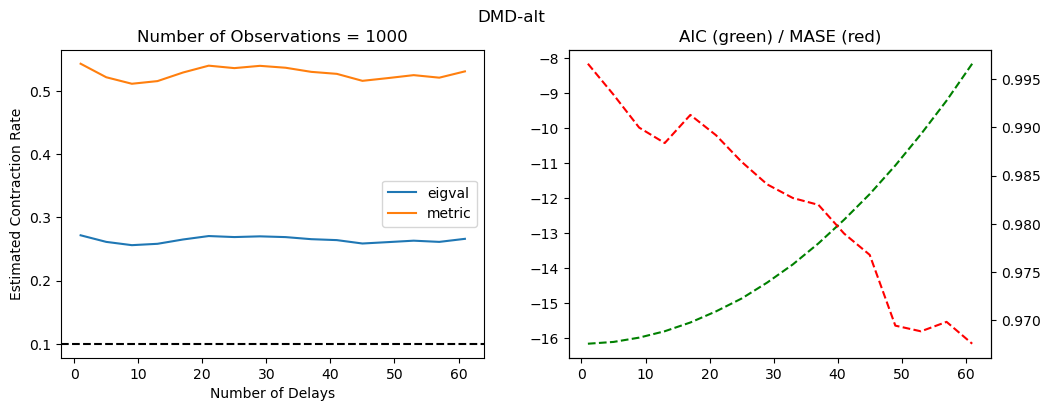

In [161]:
mode = 'DMD-alt'

plt.figure(figsize=(12, 4))
num = 23
plt.subplot(1, 2, 1)
plt.plot(list(CR_log[mode].keys())[:num], list(CR_log[mode].values())[:num], label='eigval')
plt.plot(list(CR_M[mode].keys())[:num], list(CR_M[mode].values())[:num], label='metric')
plt.legend()
# plt.plot(list(CR_I.keys())[:num], list(CR_I.values())[:num])
# plt.plot(np.array(list(CR_log.keys()))*x.shape[1][:10], CR_log.values()[:10])
# plt.plot(np.array(list(CR_I.keys()))*x.shape[1][:10], CR_I.values()[:10])
# plt.plot(delase_vals.keys(), delase_vals.values())
plt.axhline(lamb, color='k', linestyle='--')
# plt.ylim([0.6, 1])
# plt.xlim([0, 20])
# plt.ylim([-10, 10])
# plt.xlabel('Number of Delays')
plt.xlabel('Number of Delays')
plt.ylabel('Estimated Contraction Rate')
plt.title(f"Number of Observations = {num_obs}")
# plt.axhline(lam, linestyle-;00

plt.subplot(1, 2, 2)
ax = plt.gca()
lns = []

lns += ax.plot(list(CR_log[mode].keys())[:num], aic_vals[mode][:num], c='g', linestyle='--', label='aic')

ax2 = plt.gca().twinx()
# ax2 = ax
lns += ax2.plot(list(CR_log[mode].keys())[:num], mase_vals[mode][:num], c='r', linestyle='--', label='mase')
# ax2.legend(lns, [ln.get_label() for ln in lns])
ax.set_title('AIC (green) / MASE (red)')
plt.suptitle(f"{mode}")

plt.show()

# Simple Koopman System

In [109]:
def simple_system(t, x, lamb=-3, mu=-2):
    return [mu*x[0], lamb*(x[1] - x[0]**2)]

In [130]:
t_span = [0, 10]
dt = 0.01
t_eval = np.arange(t_span[0], t_span[1], dt)
x0 = [40, -20]

lamb = -3
mu = -2

sol = solve_ivp(lambda t, x: simple_system(t, x, lamb=lamb, mu=mu), t_span=t_span, y0=x0, t_eval=t_eval)
x = sol.y.T

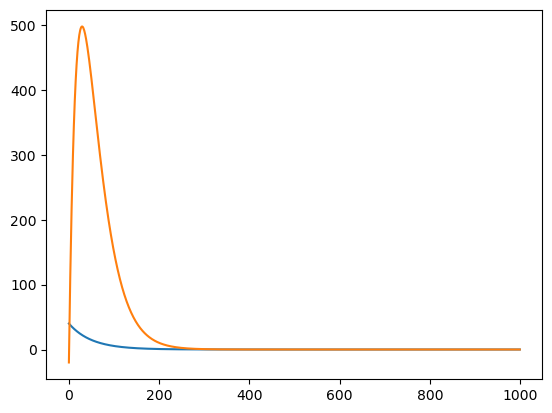

In [131]:
plt.plot(x)
plt.show()

In [141]:
Mx = lambda t, x: np.array([[1 + 4*(x[0]**2), 0], [0, 1]])
Mx_dot = lambda t, x: np.array([[8*mu*(x[0]**2), 0], [0, 0]])
CR = 2*mu

In [142]:
right_side = -2*CR*np.array([np.linalg.eigvals(Mx(t, x[t])).max() for t in range(len(t_eval))])

In [145]:
J = lambda t, x: np.array([[1, 0], [2*x[0], 1]])
left_side = np.array([np.linalg.eigvals(Mx(t, x[t])@J(t, x[t]) + J(t, x[t]).T@Mx(t, x[t]) + Mx_dot(t, x[t])).max() for t in range(len(t_eval))])

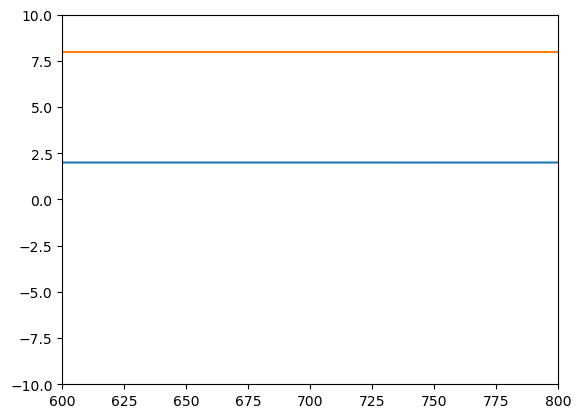

In [151]:
plt.plot(left_side)
plt.plot(right_side)
plt.xlim([600, 800])
plt.ylim([-10, 10])
plt.show()